In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import casadi as ca
from pytope import Polytope
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal

In [2]:
data_id = "08"
track_id  = 318

background_filepath = f"../data/{data_id}_background.png"
recordingMeta_filepath = f"../data/{data_id}_recordingMeta.csv"
tracks_filepath = f"../data/{data_id}_tracks.csv"
tracksMeta_filepath = f"../data/{data_id}_tracksMeta.csv"

tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == track_id]

xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
acc_vals= np.vstack((xAcc,yAcc))
N_Sam = acc_vals.shape[1]

xPos = filtered_data["xCenter"].to_numpy()
yPos = filtered_data["yCenter"].to_numpy()
position_vals = np.vstack((xPos,yPos))

SV_x = xPos
SV_y = yPos

xVel = filtered_data["xVelocity"].to_numpy()
yVel = filtered_data["yVelocity"].to_numpy()
velocity_vals = np.vstack((xVel,yVel))

yaw = filtered_data["heading"].to_numpy()

recordingMeta = pd.read_csv(recordingMeta_filepath)
orthoPxToMeter = recordingMeta["orthoPxToMeter"].iloc[0]

vehicle_data = pd.read_csv(tracksMeta_filepath)
filtered_vehicle_param = vehicle_data[vehicle_data['trackId'] == track_id]
sv_width = filtered_vehicle_param["width"]
sv_length = filtered_vehicle_param["length"]
sv_lifetime = filtered_vehicle_param["numFrames"].to_numpy().item()

In [3]:
def gen_drive_area(vertices):
    Drive_Area = Polytope(vertices*(0.00814636091724916*12))
    Drive_Area_visual = Polytope(vertices)
    A_road = Drive_Area.A
    b_road = Drive_Area.b
    return Drive_Area, Drive_Area_visual, A_road, b_road

road_vertices = np.array([
    # [294, -59],
    # [590, -388],
    # [731, -221],
    # [473, 88],

    # [258, -56],
    # [799, -671],
    # [829, -643],
    # [281, -45]

    [297, -24],
    [847, -623],
    [869, -607],
    [332, -7]


])

not_road_vertices = [
    # np.array([
    #     [303, -30],
    #     [548, -290],
    #     [701, -151],
    #     [473, 88]
    #  ]),
    np.array([
    [0, 1],
    [1, 1],
    [1,  0],
    [0, 0]
    ]),
]

Drive_Area, Drive_Area_visual, A_road, b_road = gen_drive_area(road_vertices)
not_Drive_Area = []
not_Drive_Area_visual = []
not_A_road = []
not_b_road = []
for i in range(len(not_road_vertices)):
    tmp1, tmp2, tmp3, tmp4 = gen_drive_area(not_road_vertices[i])
    not_Drive_Area.append(tmp1)
    not_Drive_Area_visual.append(tmp2)
    not_A_road.append(tmp3)
    not_b_road.append(tmp4)

In [4]:
image_param = {
  "datasets": {
    "ind": {
      "scale_down_factor": 12,  
      "relevant_areas": { 
        "1": {
          "x_lim": [2000, 11500],  
          "y_lim": [9450, 0]  
        },
        "2": {
          "x_lim": [0, 12500],
          "y_lim": [7400, 0]
        },
        "3": {
          "x_lim": [0, 11500],
          "y_lim": [9365, 0]
        },
        "4": {
          "x_lim": [2700, 15448],
          "y_lim": [9365, 0]
        }
      }
    }
  }
}
location_id = "2"
scale_down_factor = image_param["datasets"]["ind"]["scale_down_factor"]
x_lim_0 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["x_lim"][0]/scale_down_factor
x_lim_1 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["x_lim"][1]/scale_down_factor
y_lim_0 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["y_lim"][0]/scale_down_factor
y_lim_1 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["y_lim"][1]/scale_down_factor
x_lim_0 = 200
x_lim_1 = 900
y_lim_0 = 700
y_lim_1 = 0
image_to_real = orthoPxToMeter*scale_down_factor
real_to_image = 1/image_to_real

In [5]:
class polytope_estimation_OR():
    def __init__(self, Param):

        self.SV_Acc = Param["init_acc"]
        self.N = Param["N"] 
        self.T = Param["T"] 
        self.radius = Param["radius"]
        self.num_vertices = Param["num_vertices"]
        self.l_f = Param["l_f"] 
        self.l_r = Param["l_r"] 
        self.l_veh = Param["l_veh"] 
        self.w_veh = Param["w_veh"] 
        self.DEV = Param["DEV"]
        self.Q1 = Param["Q1"]
        self.Q2 = Param["Q2"]
        self.Q3 = Param["Q3"]
        self.Q4 = Param["Q4"]
        self.Q5 = Param["Q5"]
        self.Q6 = Param["Q6"]
        self.Q7 = Param["Q7"]
        self.Q8 = Param["Q8"]
        self.d_min = Param["d_min"]
        self.A_road = Param["A_road"]
        self.b_road = Param["b_road"]
        self.not_A_road = Param["not_A_road"]
        self.not_b_road = Param["not_b_road"]
        self.v_low = Param["v_low"]
        self.v_up = Param["v_up"]
        self.acc_low = Param["acc_low"]
        self.acc_up = Param["acc_up"]
        self.delta_low = Param["delta_low"]
        self.delta_up = Param["delta_up"]
        self.RefSpeed = Param["RefSpeed"]
        self.RefPos = Param["RefPos"]
        self.risk = 1
        self.last_yaw = 0
        self.last_pos = np.zeros((2,1))
        
        self.U_SV_Poly = self.Generate_Polytope(self.radius,self.num_vertices)
        self.H = self.U_SV_Poly.A 
        self.h = self.U_SV_Poly.b 
        self.nv = np.size(self.H, 0)
        self.nu = np.size(self.H, 1)
        for i in range(self.nv):
            self.H[i,:] /= self.h[i]
        self.h = np.ones_like(self.h)
        self.N_Sam = self.SV_Acc.shape[1]

        self.LP = self.OR_LP()
        self.theta_pre,self.y_pre,self.rho_pre = self.LP(np.array([[0],[0]]),np.zeros((self.nu,1)),0.1*np.ones((self.nv,1)))
        self.MPC = self.MPCFormulation()


    def Return(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, SV_Heading_new, current_x_EV):

        RefSpeed = self.RefSpeed
        RefPos = self.RefPos
        
        risk = self.risk_estimation(SV_Pos_new,SV_Heading_new)
        G, g, Occupancy_SV, = self.ReachableSet(SV_Acc_new, SV_Pos_new, SV_Vel_new, risk)
        RefXPos = RefPos[0]
        RefYPos = RefPos[1]
        RefPhi  = RefPos[2]
        Trajectory_k, Control_k, J_k, s_k = self.MPC(G, g, current_x_EV, RefSpeed, RefXPos, RefYPos, RefPhi)
        Trajectory_k = Trajectory_k.full( )
        Control_k = Control_k.full( )
        self.last_yaw = SV_Heading_new
        self.last_pos = SV_Pos_new
        return Control_k[:, 0], Trajectory_k, J_k.full( ), Occupancy_SV, risk
    
    def risk_estimation(self,SV_Pos_new,SV_Heading_new):
        risk = 0
        yaw = self.last_yaw
        x_pos = self.last_pos[0].item()
        y_pos = self.last_pos[1].item()
        x = SV_Pos_new[0].item()
        y = SV_Pos_new[1].item()
        dx = np.cos(yaw)
        dy = np.sin(yaw)
        vx = x - x_pos
        vy = y - y_pos
        distance = abs(dx * vy - dy * vx).item()
        if SV_Heading_new > np.pi:
            SV_Heading_new = SV_Heading_new - 2*np.pi
        if yaw > np.pi:
            yaw = yaw - 2*np.pi
        head_diff = (abs(SV_Heading_new)-abs(yaw)).item()

        y_mean = 0
        head_mean = 0
        y_expand = 0.7
        head_expand = 0.4
        y_sigma = y_expand/2
        head_sigma = head_expand/2
        correlation = 0
        mean = [y_mean, head_mean]
        cov = [[y_sigma**2, correlation],
        [correlation, head_sigma**2]]
        rv = multivariate_normal(mean, cov)
        pdf_value = rv.pdf([distance,head_diff])
        max_pdf_value = 1 / (2 * np.pi * y_sigma * head_sigma)
        risk = pdf_value/max_pdf_value
        if risk < 0.01:
            risk = 0.01
        if risk > 1:
            risk = 1
        return risk

    def ReachableSet(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, risk):

        self.U_Hat_Poly = self.OR(SV_Acc_new)

        A_SV = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        B_SV = np.array([[0.5*self.T**2, 0], [self.T, 0], [0, 0.5*self.T**2], [0, self.T]])
        BU = B_SV*self.U_Hat_Poly
        Reachable_Set = list()
        Occupancy_SV = list()

        x_t = np.array([SV_Pos_new[0], SV_Vel_new[0], SV_Pos_new[1], SV_Vel_new[1]])
        Reachable_Set.append(x_t)
        G = np.zeros((4, 2*self.N)) 
        g = np.zeros((4, self.N))

        for t in range(1,self.N+1):
            if t == 1:
                reachable_set_t = (A_SV@Reachable_Set[t - 1] + BU) 
            else:
                reachable_set_t = (A_SV*Reachable_Set[t - 1] + BU) 
            
            vertex = reachable_set_t.V
            vertex_xy = np.delete(vertex, [1, 3], axis = 1)
            
            # Calculate center of the polytope
            center = np.mean(vertex_xy, axis=0)
            
            # Scale vertices around the center
            scaled_vertex = center + risk * (vertex_xy - center)
            
            occupancy_SV_t = Polytope(scaled_vertex) 
            occupancy_SV_t.minimize_V_rep()
            temp_poly = occupancy_SV_t
            G[:, 2*t-2:2*t] = temp_poly.A
            g[:, t-1] = temp_poly.b.reshape(4, )

            Occupancy_SV.append(temp_poly)
            Reachable_Set.append(reachable_set_t)

        return G, g, Occupancy_SV
    
    def MPCFormulation(self):

        d_min = self.d_min          #minimum distance
        N = self.N                  #prediction length
        DEV = self.DEV              #dimension
        T = self.T                  #sampling interval
        Q1 = self.Q1                #weighting matrix steering wheel angle
        Q2 = self.Q2                #weighting matrix longitudinal jerk
        Q3 = self.Q3                #weighting matrix long. velocity error
        Q4 = self.Q4                #weighting matrix long. pos. error
        Q5 = self.Q5                #weighting matrix lat. pos. error
        Q6 = self.Q6                #weighting matrix heading. error
        Q7 = self.Q7                #weighting matrix slack variable
        Q8 = self.Q8
        A_road = self.A_road        #driving area.A
        b_road = self.b_road        #driving area.B
        not_A_road = self.not_A_road        #driving not_area.A
        not_b_road = self.not_b_road        #driving not_area.B
        v_up = self.v_up 
        v_low = self.v_low
        acc_low = self.acc_low 
        acc_up = self.acc_up 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = ca.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        delta = U[0, :]
        eta   = U[1, :]
        lam = opti.variable(4, N)
        s   = opti.variable(N, 1)
        alpha = opti.variable(N, 1) # risk factor

        G = opti.parameter(4, 2*N)
        g = opti.parameter(4, N)
        Initial = opti.parameter(DEV, 1)
        v_ref = opti.parameter( )
        x_ref = opti.parameter( )
        y_ref = opti.parameter( )
        phi_ref = opti.parameter( )

        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], delta[k], eta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, delta[k], eta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, delta[k], eta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3, delta[k], eta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
        x = X[0, 1::]
        y = X[1, 1::]
        phi = X[2, 1::]
        v = X[3, 1::]
        a = X[4, 1::]
        phi_error = phi[-1] - phi_ref
        v_error = v[-1] - v_ref # longitudinal speed error
        x_error = x[-1] - x_ref # longitudinal position error
        y_error = y[-1] - y_ref # lateral position error

        tmp1 = opti.variable(4,N)
        J = 0
        

        for k in range(N):
            p_point = X[0:2, k + 1]
            
            G_point = G[:, 2*k:2*k + 2]
            g_point = g[:, k]

            temp = G_point.T@lam[:, k]
            opti.subject_to((G_point@ca.reshape(p_point,2,1) - g_point).T@lam[:, k] >= d_min - s[k])
            opti.subject_to(temp[0]**2 + temp[1]**2 == 1)
            opti.subject_to(0 <= lam[:, k])
            opti.subject_to(A_road@ca.reshape(p_point,2,1) <= b_road)

            opti.subject_to((not_A_road[0]@ca.reshape(p_point,2,1)-not_b_road[0]).T@tmp1[:,k] >= 0.5)#- s1[k])
            opti.subject_to(ca.dot(not_A_road[0].T@tmp1[:,k],not_A_road[0].T@tmp1[:,k])<=1)

        opti.subject_to(opti.bounded(0, tmp1, ca.inf))

        opti.subject_to(opti.bounded(0, alpha, 1))
        opti.subject_to(opti.bounded(0, s, d_min))
        # opti.subject_to(0 <= s)
        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(acc_low, a, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J += delta@Q1@delta.T + eta@Q2@eta.T + Q3*v_error@v_error.T + Q4*x_error@x_error.T + Q5*y_error@y_error.T + Q6*phi_error@phi_error.T + Q7*s.T@s
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0, "print_time": False} #"ipopt.linear_solver": "ma57",
        opti.solver('ipopt', opts)

        return opti.to_function('g', [G, g, Initial, v_ref, x_ref, y_ref, phi_ref], [X, U, J, s])
    
    #kinematic unicycle model
    def vehicle_model_1(self, w, omega, eta):
        x     = w[0]
        y     = w[1]
        theta = w[2]
        v     = w[3]
        a     = w[4]

        x_dot     = v * ca.cos(theta)
        y_dot     = v * ca.sin(theta)
        theta_dot = omega
        v_dot     = a
        a_dot     = eta

        return ca.vertcat(x_dot, y_dot, theta_dot, v_dot, a_dot)

    #kinematic bicycle model
    def vehicle_model_1(self, w, delta, eta): 
        l_f = self.l_f
        l_r = self.l_r
        L = l_f + l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        # phi_dot = w[3] / L * ca.tan(delta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)
    
    #ackerman steering model
    def vehicle_model(self, w, delta, eta):
        l_f = self.l_f 
        l_r = self.l_r  
        W = self.w_veh
        L = l_f + l_r

        R = L / np.tan(delta)
        delta_inner = ca.atan(L / (R - W / 2))
        delta_outer = ca.atan(L / (R + W / 2))
        delta_avg = ca.if_else(ca.fabs(delta) < 1e-4, delta, (delta_inner + delta_outer) / 2)

        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta_avg))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

    def Generate_Polytope(self, radius, num_vertices):

        if num_vertices != 4:
            angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
            x_coords = radius * np.cos(angles)
            y_coords = radius * np.sin(angles)

            vertices = np.column_stack((x_coords, y_coords))
            U_SV_Poly = Polytope(vertices)

            return U_SV_Poly
        else:
            low_bound_control  = (-radius, -radius)
            up_bound_control   = (radius,   radius)
            U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
            return U_SV_Poly  


    def OR_LP(self):

        H = self.H
        nv = self.nv
        nu = self.nu

        opti = ca.Opti()

        rho = opti.variable()
        theta = opti.variable(nv,1)
        y = opti.variable(nu,1)

        samples = opti.parameter(nu, 1)
        y_pre = opti.parameter(nu,1)
        theta_pre = opti.parameter(nv,1)

        opti.minimize(rho + np.ones((1, nv))@theta)

        opti.subject_to(H @ samples-H @ y <= theta)
        opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
        opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho@np.ones((nv,1)))

        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho])    
    

    def OR(self,SV_Acc_new):

        self.theta_pre,self.y_pre,self.rho_pre = self.LP(SV_Acc_new,self.y_pre,self.theta_pre)
        U_Hat_Poly = Polytope(self.H, self.theta_pre)+self.y_pre

        return U_Hat_Poly
    

    def Plot_Polytope(self):

        plt.figure()
        self.U_SV_Poly.plot(color = 'b', alpha = 0.1)
        self.U_Hat_Poly.plot(color = 'r', alpha = 0.1)

        plt.scatter(self.SV_Acc[0,:],self.SV_Acc[1,:],marker='x',color = 'black')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Polytope Visualization")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()


    # def vehicle_model(self, w, delta, eta):
        
    #     l_f = self.l_f
    #     l_r = self.l_r
        
    #     beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
    #     x_dot   = w[3]*np.cos(w[2] + beta) 
    #     y_dot   = w[3]*np.sin(w[2] + beta)
    #     phi_dot = w[3]/(l_r)*np.sin(beta)
    #     v_dot = w[4]
    #     a_dot = eta
        
    #     return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

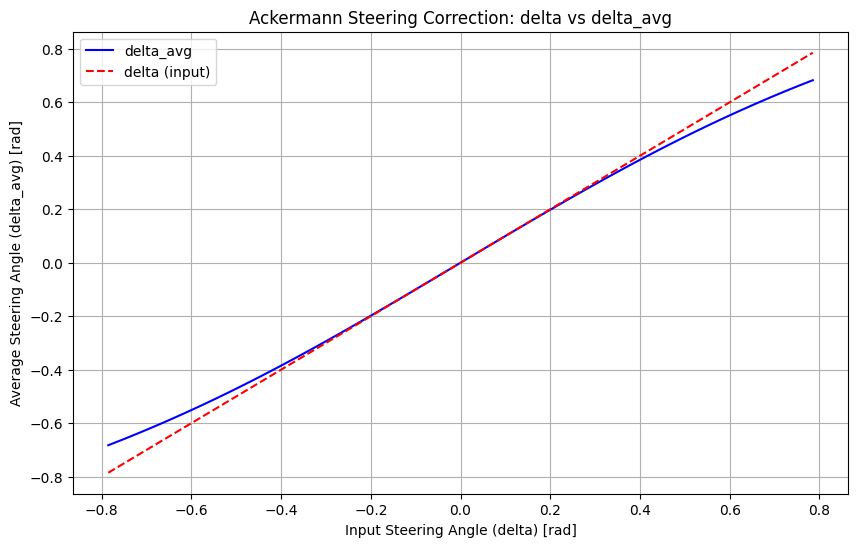

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_delta_vs_delta_avg(l_f, l_r, W, delta_min=-np.pi/4, delta_max=np.pi/4, num_points=100):
    delta_values = np.linspace(delta_min, delta_max, num_points)
    delta_avg_values = []
    
    for delta in delta_values:
        # Avoid division by zero for delta ≈ 0
        if abs(delta) < 1e-6:
            delta_avg_values.append(0.0)
            continue
            
        # Compute turning radius
        R = (l_f + l_r) / delta
        
        # Compute inner and outer wheel angles (Ackermann geometry)
        delta_outer = np.arctan((l_f + l_r) / (R + W/2))
        delta_inner = np.arctan((l_f + l_r) / (R - W/2))
        
        # Average angle (simplified for bicycle model)
        delta_avg = (delta_outer + delta_inner) / 2
        delta_avg_values.append(delta_avg)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(delta_values, delta_avg_values, 'b-', label='delta_avg')
    plt.plot(delta_values, delta_values, 'r--', label='delta (input)')
    plt.xlabel('Input Steering Angle (delta) [rad]')
    plt.ylabel('Average Steering Angle (delta_avg) [rad]')
    plt.title('Ackermann Steering Correction: delta vs delta_avg')
    plt.grid(True)
    plt.legend()
    plt.show()

l_f = 1.5  # Front axle distance (m)
l_r = 1.5  # Rear axle distance (m)
W = 1.8    # Track width (m)
plot_delta_vs_delta_avg(l_f, l_r, W)

In [7]:
Param = {
    "init_acc": acc_vals[:,0].reshape(2,1),
    "N": 10, # Reachability Prediction Length
    "T": 0.24, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.4, # Distance from CoG to Rear Axle
    "l_veh": 4.7, # length of vehicle
    "w_veh": 1.8, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 10, # long. pos. error
    "Q5": 10, # lat. pos. error
    "Q6": 1, # heading. error
    "Q7": 300,
    "Q8": 100,
    "d_min": 6,
    "A_road": A_road,
    "b_road": b_road,
    "not_A_road": not_A_road, # list
    "not_b_road": not_b_road, # list
    "v_low": -1,
    "v_up": 6,
    "acc_low": -5,
    "acc_up": 3,
    "delta_low": -0.7,
    "delta_up": 0.7,
    "RefSpeed": 0,
    # "RefPos": [686*image_to_real,-208*image_to_real,-0.744+np.pi/2]
    "RefPos": [347*image_to_real,-48*image_to_real,3*np.pi/4]
}

x_EV_initial = np.array([825*image_to_real, -584*image_to_real, 3*np.pi/4, 0, 0]) #bot

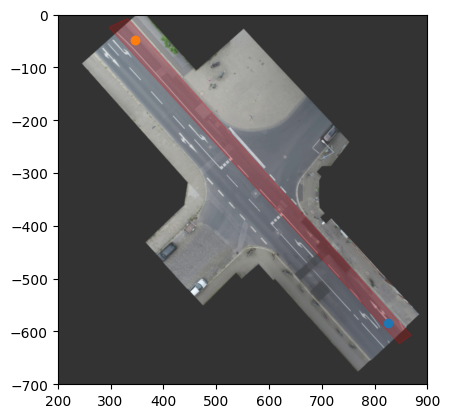

In [8]:
fig, ax = plt.subplots()
img   = mpimg.imread(background_filepath)
Drive_Area_visual.plot(color = 'r', alpha = 0.2)
for i in range(len(not_Drive_Area_visual)):
    not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)
plt.imshow(img,alpha = 0.8, extent=[0, img.shape[1], -img.shape[0], 0])
plt.scatter(x_EV_initial[0]*real_to_image,x_EV_initial[1]*real_to_image)
plt.scatter(Param["RefPos"][0]*real_to_image,Param["RefPos"][1]*real_to_image)
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([-y_lim_0,-y_lim_1])
plt.show()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



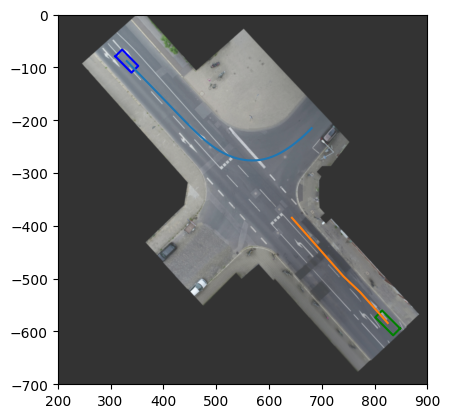

In [9]:
#test mpc
Simulation_time = N_Sam//6
test_polytope = polytope_estimation_OR(Param)
State_EV_R     = np.zeros((5, Simulation_time+1))
State_EV_R[:, 0] = x_EV_initial
X_EV_Planning_R = list( )

fig, ax = plt.subplots()
img   = mpimg.imread(background_filepath)
half_width_sv = real_to_image*sv_width / 2
half_length_sv = real_to_image*sv_length / 2
half_width_ev = real_to_image*Param["w_veh"] / 2
half_length_ev = real_to_image*Param["l_veh"] / 2

#track id
sv = track_id

for i in range(0,Simulation_time):
    track_time = i*6
    x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xAcceleration'].to_numpy()
    y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yAcceleration'].to_numpy()
    x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xCenter'].to_numpy()
    y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yCenter'].to_numpy()
    x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xVelocity'].to_numpy()
    y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yVelocity'].to_numpy()
    yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['heading'].to_numpy()
    if track_time < sv_lifetime and track_time >= 0:
        SV_acc = np.vstack((x_acc,y_acc))
        SV_position = np.vstack((x_center,y_center))
        SV_velocity = np.vstack((x_vel,y_vel))
        SV_yaw = np.radians(yaw)
    else:
        SV_acc = np.zeros((2,1))
        SV_position = np.zeros((2,1))
        SV_velocity = np.zeros((2,1))
        SV_yaw = np.zeros((1,1))
    #   U_R: input, trajectory_planning_k: predicted EV, J_R:cost, Occupancy_SV_aug_R:Occupancy
    U_R, trajectory_planning_k, J_R, Occupancy_SV_aug_R, risk = test_polytope.Return(SV_acc, SV_position, SV_velocity, SV_yaw, State_EV_R[:, i])
    X_EV_Planning_R.append(trajectory_planning_k[0:2,1].reshape(2,1))
    State_EV_R[:, i + 1] = trajectory_planning_k[:, 1]
    if i % 80 == 0 or i == N_Sam-1:
        corners_sv = np.array([
            [-half_length_sv, -half_width_sv],
            [half_length_sv, -half_width_sv],
            [half_length_sv, half_width_sv],
            [-half_length_sv, half_width_sv]
        ])
        rad_yaw_sv = SV_yaw.item()
        rotation_matrix_sv = np.array([
                [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
                [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
            ])
        rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
        rotated_corners_sv[:, 0] += SV_position[0]*real_to_image
        rotated_corners_sv[:, 1] += SV_position[1]*real_to_image
        rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
        plt.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'b-')

        corners_ev = np.array([
            [-half_length_ev, -half_width_ev],
            [half_length_ev, -half_width_ev],
            [half_length_ev, half_width_ev],
            [-half_length_ev, half_width_ev]
        ])
        rad_yaw_ev = trajectory_planning_k[2,1]
        rotation_matrix_ev = np.array([
                [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
                [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
            ])
        rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
        rotated_corners_ev[:, 0] += State_EV_R[0, i+1]*real_to_image
        rotated_corners_ev[:, 1] += State_EV_R[1, i+1]*real_to_image
        rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
        plt.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'g-')

        for i in range(Param["N"]):
            occupancy = Polytope(Occupancy_SV_aug_R[i].A, Occupancy_SV_aug_R[i].b*real_to_image)
            occupancy.plot(color = 'b', alpha = 0.5)
            
# Drive_Area_visual.plot(color = 'r', alpha = 0.2)
# for i in range(len(not_Drive_Area_visual)):
#     not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)

plt.imshow(img,alpha = 0.8, extent=[0, img.shape[1], -img.shape[0], 0])
plt.plot(SV_x*real_to_image, SV_y*real_to_image)
plt.plot(State_EV_R[0]*real_to_image, State_EV_R[1]*real_to_image)
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([-y_lim_0,-y_lim_1])
plt.show()

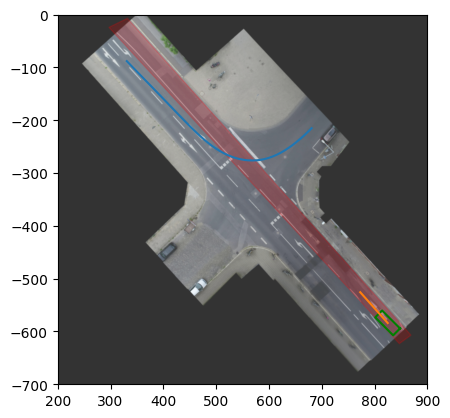

In [10]:
test_polytope = polytope_estimation_OR(Param)
fig, ax = plt.subplots()
img = mpimg.imread(background_filepath)

half_width_sv = real_to_image*sv_width / 2
half_length_sv = real_to_image*sv_length / 2
half_width_ev = real_to_image*Param["w_veh"] / 2
half_length_ev = real_to_image*Param["l_veh"] / 2
Simulation_time = N_Sam//6
frame_length = Simulation_time + 30
sv = track_id

ax.imshow(img, alpha=0.8, extent=[0, img.shape[1], -img.shape[0], 0])
ax.set_xlim([x_lim_0, x_lim_1])
ax.set_ylim([-y_lim_0, -y_lim_1])

State_EV_R = np.zeros((5, frame_length + 1))
State_EV_R[:, 0] = x_EV_initial
X_EV_Planning_R = []


def draw_vehicle(ax, corners, rotation_matrix, position, color):
    rotated_corners = corners.reshape(4,2) @ rotation_matrix.T
    rotated_corners[:, 0] += position[0]
    rotated_corners[:, 1] += position[1]
    rotated_corners = np.vstack([rotated_corners, rotated_corners[0]]) 
    ax.plot(rotated_corners[:, 0], rotated_corners[:, 1], color)

corners_sv = np.array([
    [-half_length_sv, -half_width_sv],
    [half_length_sv, -half_width_sv],
    [half_length_sv, half_width_sv],
    [-half_length_sv, half_width_sv]
])
corners_ev = np.array([
    [-half_length_ev, -half_width_ev],
    [half_length_ev, -half_width_ev],
    [half_length_ev, half_width_ev],
    [-half_length_ev, half_width_ev]
])

def update(frame):
    ax.clear()
    ax.imshow(img, alpha=0.8, extent=[0, img.shape[1], -img.shape[0], 0])
    ax.set_xlim([x_lim_0, x_lim_1])
    ax.set_ylim([-y_lim_0, -y_lim_1])
    
    global State_EV_R
    track_time = frame*6-50
    if track_time < sv_lifetime and track_time >= 0:
        x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xAcceleration'].to_numpy()
        y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yAcceleration'].to_numpy()
        x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xCenter'].to_numpy()
        y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yCenter'].to_numpy()
        x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xVelocity'].to_numpy()
        y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yVelocity'].to_numpy()
        yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['heading'].to_numpy()
        SV_acc = np.vstack((x_acc,y_acc))
        SV_position = np.vstack((x_center,y_center))
        SV_velocity = np.vstack((x_vel,y_vel))
        SV_yaw = np.radians(yaw)
    elif track_time < 0:
        SV_acc = np.zeros((2,1))
        SV_position = np.zeros((2,1))
        SV_velocity = np.zeros((2,1))
        SV_yaw = np.zeros((1,1))
    else:
        x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['xAcceleration'].to_numpy()
        y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['yAcceleration'].to_numpy()
        x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['xCenter'].to_numpy()
        y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['yCenter'].to_numpy()
        x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['xVelocity'].to_numpy()
        y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['yVelocity'].to_numpy()
        yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['heading'].to_numpy()
        SV_acc = np.vstack((x_acc,y_acc))
        SV_position = np.vstack((x_center,y_center))
        SV_velocity = np.vstack((x_vel,y_vel))
        SV_yaw = np.radians(yaw)
    U_R, trajectory_planning_k, J_R, Occupancy_SV_aug_R, risk = test_polytope.Return(SV_acc,SV_position,SV_velocity, SV_yaw, State_EV_R[:, frame])
    X_EV_Planning_R.append(trajectory_planning_k[0:2, 1].reshape(2, 1))
    State_EV_R[:, frame + 1] = trajectory_planning_k[:, 1]

    rad_yaw_sv = SV_yaw.item()
    rotation_matrix_sv = np.array([
        [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
        [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
    ])
    draw_vehicle(ax, corners_sv, rotation_matrix_sv, [SV_position[0]*real_to_image, SV_position[1]*real_to_image], 'b-')

    rad_yaw_ev = trajectory_planning_k[2, 1]
    rotation_matrix_ev = np.array([
        [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
        [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
    ])
    draw_vehicle(ax, corners_ev, rotation_matrix_ev, [State_EV_R[0, frame + 1]*real_to_image,
                                                    State_EV_R[1, frame + 1]*real_to_image], 'g-')

    for i in range(Param["N"]):
        occupancy = Polytope(Occupancy_SV_aug_R[i].A, Occupancy_SV_aug_R[i].b*real_to_image)
        occupancy.plot(color='b', alpha=0.3)

    ax.plot(SV_x*real_to_image, SV_y*real_to_image)
    #print(trajectory_planning_k.shape)
    ax.plot(trajectory_planning_k[0]*real_to_image,trajectory_planning_k[1]*real_to_image)
    Drive_Area_visual.plot(color='r', alpha=0.2)
    for i in range(len(not_Drive_Area_visual)):
        not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)

ani = FuncAnimation(fig, update, frames=range(0, frame_length), interval=100, repeat=False)
#plt.show()
ani.save("../videos/inD_MPC/inD_risk_simulation.mp4", writer='ffmpeg', fps=15)

In [11]:
from IPython.display import Video

# Specify the full file path
video_path = "../videos/inD_MPC/inD_risk_simulation.mp4"

# Display the video
Video(video_path, embed=True)

/var/folders/y4/8m7zvb3s42z21rz3sv9j00gr0000gn/T/ipykernel_5243/2891302490.py:140: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


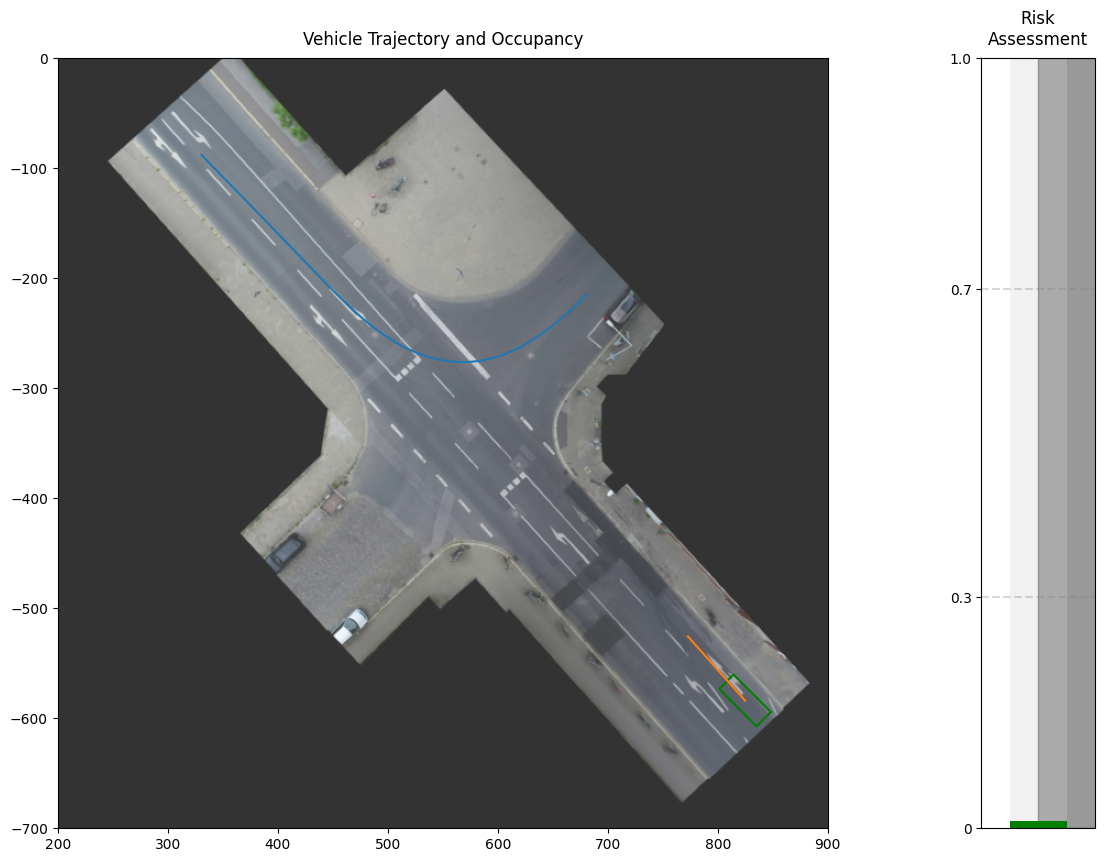

In [12]:
import warnings
warnings.filterwarnings("ignore", message=".*This figure includes Axes that are not compatible with tight_layout.*")

test_polytope = polytope_estimation_OR(Param)
fig = plt.figure(figsize=(15, 10),constrained_layout=True)
gs = plt.GridSpec(1, 2, width_ratios=[9, 1], wspace=0.05)
ax = fig.add_subplot(gs[0])
risk_ax = fig.add_subplot(gs[1])
img = mpimg.imread(background_filepath)

half_width_sv = real_to_image*sv_width / 2
half_length_sv = real_to_image*sv_length / 2
half_width_ev = real_to_image*Param["w_veh"] / 2
half_length_ev = real_to_image*Param["l_veh"] / 2
Simulation_time = N_Sam//6
frame_length = Simulation_time + 70
sv = track_id

ax.imshow(img, alpha=0.8, extent=[0, img.shape[1], -img.shape[0], 0])
ax.set_xlim([x_lim_0, x_lim_1])
ax.set_ylim([-y_lim_0, -y_lim_1])

State_EV_R = np.zeros((5, frame_length + 1))
State_EV_R[:, 0] = x_EV_initial
X_EV_Planning_R = []
risk_history = []

def draw_vehicle(ax, corners, rotation_matrix, position, color):
    rotated_corners = corners.reshape(4,2) @ rotation_matrix.T
    rotated_corners[:, 0] += position[0]
    rotated_corners[:, 1] += position[1]
    rotated_corners = np.vstack([rotated_corners, rotated_corners[0]]) 
    ax.plot(rotated_corners[:, 0], rotated_corners[:, 1], color)

corners_sv = np.array([
    [-half_length_sv, -half_width_sv],
    [half_length_sv, -half_width_sv],
    [half_length_sv, half_width_sv],
    [-half_length_sv, half_width_sv]
])
corners_ev = np.array([
    [-half_length_ev, -half_width_ev],
    [half_length_ev, -half_width_ev],
    [half_length_ev, half_width_ev],
    [-half_length_ev, half_width_ev]
])

def update(frame):
    ax.clear()
    risk_ax.clear()
    
    ax.imshow(img, alpha=0.8, extent=[0, img.shape[1], -img.shape[0], 0])
    ax.set_xlim([x_lim_0, x_lim_1])
    ax.set_ylim([-y_lim_0, -y_lim_1])
    ax.set_title('Vehicle Trajectory and Occupancy', pad=10)
    
    global State_EV_R, risk_history

    track_time = frame*6 - 50
    if track_time < sv_lifetime and track_time >= 0:
        x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xAcceleration'].to_numpy()
        y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yAcceleration'].to_numpy()
        x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xCenter'].to_numpy()
        y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yCenter'].to_numpy()
        x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xVelocity'].to_numpy()
        y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yVelocity'].to_numpy()
        yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['heading'].to_numpy()
        SV_acc = np.vstack((x_acc,y_acc))
        SV_position = np.vstack((x_center,y_center))
        SV_velocity = np.vstack((x_vel,y_vel))
        SV_yaw = np.radians(yaw)
    elif track_time < 0:
        SV_acc = np.zeros((2,1))
        SV_position = np.zeros((2,1))
        SV_velocity = np.zeros((2,1))
        SV_yaw = np.zeros((1,1))
    else:
        x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['xAcceleration'].to_numpy()
        y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['yAcceleration'].to_numpy()
        x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['xCenter'].to_numpy()
        y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['yCenter'].to_numpy()
        x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['xVelocity'].to_numpy()
        y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['yVelocity'].to_numpy()
        yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == sv_lifetime-1)]['heading'].to_numpy()
        SV_acc = np.vstack((x_acc,y_acc))
        SV_position = np.vstack((x_center,y_center))
        SV_velocity = np.vstack((x_vel,y_vel))
        SV_yaw = np.radians(yaw)
    U_R, trajectory_planning_k, J_R, Occupancy_SV_aug_R, risk = test_polytope.Return(SV_acc,SV_position,SV_velocity, SV_yaw, State_EV_R[:, frame])
    current_risk = float(risk)
    risk_history.append(current_risk)
    for i in range(Param["N"]):
        occupancy = Polytope(Occupancy_SV_aug_R[i].A, Occupancy_SV_aug_R[i].b*real_to_image)
        occupancy.plot(ax=ax, color='b', alpha=0.3)
    
    X_EV_Planning_R.append(trajectory_planning_k[0:2, 1].reshape(2, 1))
    State_EV_R[:, frame + 1] = trajectory_planning_k[:, 1]

    rad_yaw_sv = SV_yaw.item()
    rotation_matrix_sv = np.array([
        [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
        [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
    ])
    draw_vehicle(ax, corners_sv, rotation_matrix_sv, [SV_position[0]*real_to_image, SV_position[1]*real_to_image], 'b-')

    rad_yaw_ev = trajectory_planning_k[2, 1]
    rotation_matrix_ev = np.array([
        [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
        [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
    ])
    draw_vehicle(ax, corners_ev, rotation_matrix_ev, [State_EV_R[0, frame + 1]*real_to_image,
                                                    State_EV_R[1, frame + 1]*real_to_image], 'g-')

    ax.plot(SV_x*real_to_image, SV_y*real_to_image)
    
    ax.plot(trajectory_planning_k[0]*real_to_image,trajectory_planning_k[1]*real_to_image)
    Drive_Area_visual.plot(color='r', alpha=0.2)
    for i in range(len(not_Drive_Area_visual)):
        not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)
    
    risk_ax.bar([0], [1], width=0.5, color='lightgray', alpha=0.3, zorder=1)
    
    if current_risk < 0.3:
        color = 'green'
    elif current_risk < 0.7:
        color = 'yellow'
    else:
        color = 'red'
    
    risk_ax.bar([0], [current_risk], width=0.5, color=color, zorder=2)
    risk_ax.set_ylim([0, 1])
    risk_ax.set_xlim([-0.5, 0.5])
    risk_ax.set_xticks([])
    risk_ax.set_yticks([0, 0.3, 0.7, 1.0])
    risk_ax.set_yticklabels(['0', '0.3', '0.7', '1.0'])
    risk_ax.set_title('Risk\nAssessment', pad=10)
    risk_ax.axhline(y=0.3, color='gray', linestyle='--', alpha=0.3)
    risk_ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()

ani = FuncAnimation(fig, update, frames=range(0, frame_length), interval=100, repeat=False)
ani.save("../videos/inD_MPC/inD_risk_shown_simulation.mp4", writer='ffmpeg', fps=15)


In [13]:
from IPython.display import Video

# Specify the full file path
video_path = "../videos/inD_MPC/inD_risk_shown_simulation.mp4"

# Display the video
Video(video_path, embed=True)